# CESM2-LE Initial Condition Memory:  Zonal-mean TEMP
 - Use Intake to access CESM2LE data on glade
 - Compute zonal mean annual TEMP from POP monthly output for all members from 1850-2100
 - Plot time slices of micro-to-total variance
 - Request at least 50GB on Casper login to run this notebook

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
from os.path import exists
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import calc
import intake
import pop_tools
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pp_datafile = '/glade/scratch/yeager/cesm2_le/CESM2LE_zmTEMP.nc'
if (exists(pp_datafile)):
    print(pp_datafile+' already exists.\n\n')
else:
    print(pp_datafile+' does NOT exist.\n\n')

/glade/scratch/yeager/cesm2_le/CESM2LE_zmTEMP.nc does NOT exist.




If CESM2LE post-processed zonal mean SST file already exists, you don't need to do Section 1 (~30 minutes). Go to [Section 2](#section2). 

# Section 1

## Create Dask Cluster

In [9]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [ ]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(10) 

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='250GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=2:mem=250GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39958 instead
  warnings.warn(


In [4]:
cluster

## Data Intake

In [5]:
# Point to the catalog file
#catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
catalog_file = '/glade/work/mgrover/intake-esm-catalogs/glade-cesm2-le.json'

# Open the catalog using intake
col = intake.open_esm_datastore(catalog_file)

# Find POP assets
oceandata = col.search(component='ocn', variable=['TEMP'], frequency='month_1', experiment=['historical','ssp370'])

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [6]:
## Missing 1860 decade:
oceandata.search(cesm_member_id=1231.005).df

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1850-01,1859-12,185001-185912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
1,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1870-01,1879-12,187001-187912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
2,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1880-01,1889-12,188001-188912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
3,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1890-01,1899-12,189001-189912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
4,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1900-01,1909-12,190001-190912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
5,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1910-01,1919-12,191001-191912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
6,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1920-01,1929-12,192001-192912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
7,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1930-01,1939-12,193001-193912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
8,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1940-01,1949-12,194001-194912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1
9,ocn,pop.h,b.e21.BHISTcmip6.f09_g17.LE2-1231.005,r5i1231p1f1,TEMP,1950-01,1959-12,195001-195912,Potential Temperature,degC,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/o...,historical,cmip6,1231.005,1231,CESM2_historical_r5i1231p1f1


In [6]:
## Use preprocessor to return annual zonal mean TEMP
def preproc(ds):
    ds = calc.center_time(ds)
    temp_ann = ds.TEMP.groupby('time.year').mean().rename({'year':'time'})
    #zmtemp = calc.regional_zonal_mean(temp_ann,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA')
    return temp_ann.to_dataset()

In [7]:
%%time
# Create a dataset dictionary from the subsampled catalog
cbc_args = {'data_vars':'minimal'}
dsets = oceandata.to_dataset_dict(
    #xarray_combine_by_coords_kwargs=cbc_args,
    preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 23.4 s, sys: 2.09 s, total: 25.5 s
Wall time: 1min 36s


In [8]:
dsets.keys()

dict_keys(['ocn.historical.pop.h.cmip6.TEMP', 'ocn.ssp370.pop.h.cmip6.TEMP', 'ocn.historical.pop.h.smbb.TEMP', 'ocn.ssp370.pop.h.smbb.TEMP'])

In [16]:
dsets['ocn.historical.pop.h.smbb.TEMP'].isel(member_id=slice(0,25)).TEMP

<xarray.DataArray 'TEMP' (member_id: 25, time: 165, z_t: 60, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(25, 165, 60, 384, 320), dtype=float32, chunksize=(1, 1, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
  * member_id  (member_id) <U12 'r10i1191p1f2' 'r11i1231p1f2' ... 'r16i1301p1f2'
Dimensions without coordinates: nlat, nlon

In [17]:
dsets['ocn.historical.pop.h.smbb.TEMP'].isel(member_id=slice(25,None)).TEMP

<xarray.DataArray 'TEMP' (member_id: 25, time: 165, z_t: 60, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(25, 165, 60, 384, 320), dtype=float32, chunksize=(1, 1, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) int64 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
  * member_id  (member_id) <U12 'r17i1231p1f2' 'r17i1251p1f2' ... 'r9i1171p1f2'
Dimensions without coordinates: nlat, nlon

## Data Processing

#### Prepare for Zonal Mean computation in preprocessor:

In [11]:
## Define target lat_aux grid:
lat_aux = xr.DataArray(np.linspace(-90,90,181),dims='lat',attrs={'units':'degrees_north','long_name':'latitude boundaries of zonal mean'})

In [12]:
## Define target region mask
grid_ds = pop_tools.get_grid('POP_gx1v7')
rmask = grid_ds.REGION_MASK
rmask = xr.where((rmask==1) & ((grid_ds['nlon']>=54) & (grid_ds['nlon']<=293)),2,rmask)
rmask = xr.where(rmask==3,2,rmask)
rmask = xr.where(rmask==4,2,rmask)
rmask = xr.where((rmask>=6) & (rmask<=11),1,rmask)
rmask = rmask.where(rmask>0)
rmaskdict = {0:'Global',1:'Atlantic+Arctic',2:'Indo-Pacific'}

/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


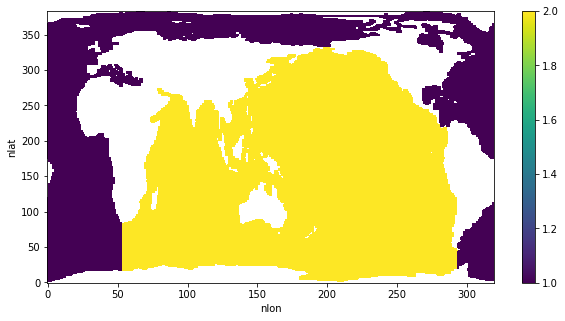

In [13]:
rmask.plot(aspect=2,size=5)

#### Compute Annual Zonal-mean from monthly TEMP:

In [18]:
from dask.distributed import wait

In [19]:
%%time
ds = dsets['ocn.historical.pop.h.cmip6.TEMP'].isel(member_id=slice(0,25)).TEMP
cmip6hist_zm1 = calc.regional_zonal_mean(ds,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').persist()
daskwait = wait(cmip6hist_zm1)

CPU times: user 4min 11s, sys: 6.94 s, total: 4min 18s
Wall time: 15min 20s


In [20]:
%%time
ds = dsets['ocn.historical.pop.h.cmip6.TEMP'].isel(member_id=slice(25,None)).TEMP
cmip6hist_zm2 = calc.regional_zonal_mean(ds,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').persist()
daskwait = wait(cmip6hist_zm2)

CPU times: user 4min 57s, sys: 7.39 s, total: 5min 4s
Wall time: 15min 30s


In [21]:
cmip6hist_zm = xr.concat([cmip6hist_zm1,cmip6hist_zm2],dim='member_id')
cmip6hist_zm

,Array,Chunk
Bytes,1.99 GiB,84.38 kiB
Shape,"(3, 50, 165, 60, 180)","(1, 1, 1, 60, 180)"
Count,49500 Tasks,24750 Chunks
Type,float64,numpy.ndarray


In [22]:
%%time
ds = dsets['ocn.historical.pop.h.smbb.TEMP'].isel(member_id=slice(0,25)).TEMP
smbbhist_zm1 = calc.regional_zonal_mean(ds,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').persist()
daskwait = wait(smbbhist_zm1)

CPU times: user 5min 42s, sys: 8.12 s, total: 5min 50s
Wall time: 17min 26s


In [23]:
%%time
ds = dsets['ocn.historical.pop.h.smbb.TEMP'].isel(member_id=slice(25,None)).TEMP
smbbhist_zm2 = calc.regional_zonal_mean(ds,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').persist()
daskwait = wait(smbbhist_zm2)

CPU times: user 5min 50s, sys: 8.2 s, total: 5min 59s
Wall time: 15min 53s


In [24]:
smbbhist_zm = xr.concat([smbbhist_zm1,smbbhist_zm2],dim='member_id')
smbbhist_zm

,Array,Chunk
Bytes,1.99 GiB,84.38 kiB
Shape,"(3, 50, 165, 60, 180)","(1, 1, 1, 60, 180)"
Count,49500 Tasks,24750 Chunks
Type,float64,numpy.ndarray


In [25]:
%%time
ds = dsets['ocn.ssp370.pop.h.cmip6.TEMP'].TEMP
cmip6ssp_zm = calc.regional_zonal_mean(ds,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').persist()
daskwait = wait(cmip6ssp_zm)

CPU times: user 7min 2s, sys: 8.88 s, total: 7min 11s
Wall time: 16min 10s


In [26]:
%%time
ds = dsets['ocn.ssp370.pop.h.smbb.TEMP'].TEMP
smbbssp_zm = calc.regional_zonal_mean(ds,grid_ds,rmask,rmaskdict,lat_axis=lat_aux,lat_field='TLAT',ydim='nlat',xdim='nlon',area_field='TAREA').persist()
daskwait = wait(smbbssp_zm)

CPU times: user 7min 33s, sys: 9.34 s, total: 7min 43s
Wall time: 17min 32s


In [27]:
## Create final Dataset:
work1 = xr.concat([cmip6hist_zm,cmip6ssp_zm],dim='time')
work2 = xr.concat([smbbhist_zm,smbbssp_zm],dim='time')
cesm2le_zm = xr.concat([work1,work2],dim='member_id')
memid = cesm2le_zm.member_id.data
inityear = xr.DataArray([i.split('i')[1].split('p')[0] for i in memid],coords={'member_id':cesm2le_zm.member_id})
memnum = xr.DataArray([i.split('i')[0].split('r')[1].rjust(3,'0') for i in memid],coords={'member_id':cesm2le_zm.member_id})

ds = cesm2le_zm.to_dataset()
ds['inityear'] = inityear
ds['memnum'] = memnum

In [28]:
ds

,Array,Chunk
Bytes,6.06 GiB,84.38 kiB
Shape,"(3, 100, 251, 60, 180)","(1, 1, 1, 60, 180)"
Count,275400 Tasks,75300 Chunks
Type,float64,numpy.ndarray


In [29]:
pp_datafile

'/glade/scratch/yeager/cesm2_le/CESM2LE_zmTEMP.nc'

In [32]:
%%time
ds1 = ds.isel(member_id=slice(0,50))
ds2 = ds.isel(member_id=slice(50,None))
pp_datafile1 = '/glade/scratch/yeager/cesm2_le/CESM2LE_zmTEMP.1.nc'
ds1.to_netcdf(pp_datafile1)
pp_datafile2 = '/glade/scratch/yeager/cesm2_le/CESM2LE_zmTEMP.2.nc'
ds2.to_netcdf(pp_datafile2)

distributed.core - ERROR - 'tcp://10.12.206.40:38421'
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/core.py", line 575, in handle_stream
    handler(**merge(extra, msg))
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/scheduler.py", line 5346, in handle_release_data
    ws: WorkerState = parent._workers_dv[worker]
KeyError: 'tcp://10.12.206.40:38421'
distributed.utils - ERROR - 'tcp://10.12.206.40:38421'
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/utils.py", line 645, in log_errors
    yield
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/scheduler.py", line 4331, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/glade/work/yeager/miniconda3/envs/cesm2-LE/lib/python3.8/site-packages/distributed/scheduler.py", 

KilledWorker: ("('concatenate-getitem-getitem-store-cf54493c-5aa4-11ec-9cb2-3cecef1b11fa', 1, 4, 55, 0, 0)", <WorkerState 'tcp://10.12.206.29:39862', name: PBSCluster-12, memory: 0, processing: 3831>)

In [31]:
%%time
## Compute and save to netcdf:
ds.to_netcdf(pp_datafile)

RuntimeError: NetCDF: HDF error

<a id='section2'></a>

# Section 2

If you skipped Section 1, read in ds for analysis and plotting:

In [ ]:
print('opening '+pp_datafile)
ds = xr.open_dataset(pp_datafile)

In [ ]:
ds

In [ ]:
# Print summary of initialization years in dataset
iyear = ds.inityear.data
print("Start Year : Members")
for i in set(iyear):
    count = np.count_nonzero(iyear==i)
    print(i+" : "+str(count).zfill(3))

Apply low-pass filter:

In [ ]:
def lpf_anndata(dat, period=10):
    fs=1/(365*24*3600)        # 1 year in Hz (sampling frequency)
    nyquist = fs / 2          # 0.5 times the sampling frequency
    cutoff = fs/period            # cutoff frequency
    cutoff = cutoff/nyquist   # as fraction of nyquist  
    print('cutoff= ',(1/(cutoff*nyquist))/(365*24*3600),' years') 
    filtsos = signal.butter(4, cutoff, 'lowpass', output='sos') #low pass filter
    filtb, filta = signal.butter(4, cutoff, 'lowpass')
    dat_out = xr.apply_ufunc(signal.sosfiltfilt, filtsos,dat.fillna(0),kwargs={'padtype':'even','axis':0}).where(dat.notnull())
    return dat_out

In [ ]:
ds['TEMP'] = lpf_anndata(ds.TEMP.transpose('time','region','member_id','TLAT_bin'),period=15)

## Guide to Micro and Macro Ensembles:
  - 20-member micro ensembles referred to by start year: 1231, 1251, 1281, 1301
  - 10-member "macro1a" ensemble, initialized: 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181
  - 10-member "macro1b" (MOAR) ensemble, initialized: 1011, 1031, 1051, 1071, 1091, 1111, 1131, 1151, 1171, 1191
  - 10-member "macro2" ensemble (CMIP6 contribution):  b.e21.BHIST.f09_g17.CMIP6-historical.{001-010}


## Decomposition of Ensemble Variance:

Following Singh et al. (2021, in review), decompose CESM2LE ensemble variance for variable X as follows: 
$$ 
\sigma^{2}_{X} = \sigma^{2}_{X,ocn} + \sigma^{2}_{X,atm} + \sigma^{2}_{X,Cov(atm,ocn)}
$$ 
where "ocn" quantifies spread between micro ensembles (due to different ocean initial conditions), and "atm" quantifies spread within micro ensembles (due to perturbed atmospheric initial conditions). Variance within micro ensembles is computed as the average ensemble variance (with p=4, m=20):
$$ 
\sigma^{2}_{X,atm} = \frac{1}{p}\sum_{k=1}^{p}\frac{\sum_{j=1}^{m}(X_{k,j}-\overline{X_{k}})^2}{m-1}
$$ 
Variance across micro ensembles is computed as:
$$ 
\sigma^{2}_{X,ocn} = \frac{\sum_{k=1}^{p}(\overline{X_{k}}-\overline{X})^2}{p-1}
$$ 
where $\overline{X}$ is the mean over the full (80 member) ensemble. The fraction of ensemble variance attributable to ocean initial conditions is then:
$$ 
\chi_{ocn}(t) = \frac{\sigma^{2}_{X,ocn}(t)}{\sigma^{2}_{X}(t)}
$$ 

In [ ]:
iyear = ds.inityear.data
memind = np.nonzero((iyear=='1231') | (iyear=='1251') | (iyear=='1281') | (iyear=='1301'))
da_allmem = ds.TEMP.isel(member_id=memind[0])
sig2_tot = da_allmem.var(dim='member_id')
allmean = da_allmem.mean(dim='member_id')

In [ ]:
# Compute Ensemble Variance Decomposition:
plist = ['1231','1251','1281','1301']
varlist = []
meanlist = []
covarlist = []
iyear = ds.inityear.data
for p in plist:
    memind = np.nonzero(iyear==p)
    da_oneinit = ds.TEMP.isel(member_id=memind[0])
    var = da_oneinit.var('member_id')
    mean = da_oneinit.mean('member_id')
    covar = (2*(da_oneinit - mean)*(mean-allmean)).mean('member_id')
    varlist.append(var)
    meanlist.append(mean)
    covarlist.append(covar)
sig2_atm = xr.concat(varlist,dim='p').mean('p')
sig2_ocn = xr.concat(meanlist,dim='p').var('p')
sig2_ocn_p = xr.concat(meanlist,dim=xr.DataArray(plist,dims='p',name='p'))
sig2_ocn_p = (sig2_ocn_p - sig2_ocn_p.mean('p'))**2
sig2_covar = xr.concat(covarlist,dim='p').mean('p')
# Compute Chi
chi_atm = (sig2_atm/sig2_tot).rename("Chi")
chi_ocn = (sig2_ocn/sig2_tot).rename("Chi")
chi_ocn_p = (sig2_ocn_p/sig2_tot).rename("Chi")
chi_covar = (sig2_covar/sig2_tot).rename("Chi")

In [ ]:
# Test for closure of variance budget:
sig2_resid = sig2_tot - (sig2_atm+sig2_ocn+sig2_covar)
#sig2_resid = sig2_tot - (sig2_atm+sig2_ocn)
sig2_resid.isel(region=0).plot(size=5)
sig2_covar.isel(region=0).plot(size=5)

In [ ]:
# Quick plot of Chi
chi = xr.concat([chi_atm,chi_ocn,chi_covar],dim=xr.DataArray(['Chi_atm','Chi_ocn','Chi_covar'],dims='term',name='term'))
levs = np.arange(0,9)*0.1
chi.isel(region=0).plot.contourf(col='term',size=5,levels=levs)

In [ ]:
#fig, axes = plt.subplots(ncols=3)
chi_ocn.plot.contourf(col='region',vmin=0,vmax=0.2,size=7)
#chi_ocn_lpf.plot.contour(col='region',levels=[0.075],size=7,colors='r')

## Compute bootstrapped significance

In [ ]:
import xskillscore as xs

Resample 80-member pool (with replacement), to generate 100 different synthetic 20-member "micro" ensembles:

In [ ]:
%%time
iterations = 100
ens_size = 20
da_micros_r = xs.resample_iterations_idx(da_micros, iterations, 'member_id', dim_max=ens_size).rename({'iteration':'micro'}).chunk().persist()

Now, resample again to generate 500 different 4-micro combinations:

In [ ]:
da_micros_rr = xs.resample_iterations(da_micros_r, 500, 'micro', dim_max=4)

Compute resampled distributions of sig2_atm, sig2_ocn, and chi_ocn:

In [ ]:
%%time
sig2_atm_r = da_micros_rr.var(dim='member_id').mean('micro').load()
sig2_ocn_r = da_micros_rr.mean(dim='member_id').var('micro').load()
sig2_tot_r = da_micros_rr.var(dim=['member_id','micro']).load()
chi_ocn_r = (sig2_ocn_r/sig2_tot_r).rename("Chi_ocn_r")

In [ ]:
# Plot with bootstrapped significance
pval = (chi_ocn_r > chi_ocn).sum('iteration')/chi_ocn_r['iteration'].size
clevs = np.arange(0,11)*0.025

g = chi_ocn.plot.contourf(col='region',size=7,levels=clevs,cmap='viridis')
for i, ax in enumerate(g.axes.flat):
    pval.isel(region=i).plot.contour(ax=ax,levels=[0.05],colors=['white'])
    if (i>0): ax.set_ylabel('')

In [ ]:
# Plot decomposition of Chi_ocn by init year:
levs = np.arange(0,11)*0.05
chi_ocn_p.plot.contourf(col='p',row='region',size=7,levels=levs)